** Importing things **

Basically ensuring we have access to all the libraries going forward

In [1]:
import csv
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2, activity_l2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pickle
import random
from sklearn import preprocessing
from sklearn.utils import shuffle
import tensorflow as tf

tf.python.control_flow_ops = tf


Using TensorFlow backend.


** Image transformation functions **

In [2]:
# Reflection transformation
def reflect_image(image):
    return cv2.flip(image, 1)

class reflection(object):
    def __init__(self, images):
        self.images = images
        self.current = 0
        self.size = len(images)
    def __iter__(self):
        return self
    def __next__(self):
        return self._next()
    def _next(self):
        if self.current < self.size:
            image, self.current = self.images[self.current], self.current + 1
            return reflect_image(image)
        else:
            raise StopIteration()

In [3]:
# Image resize
def resize_image(image_in, dimensions=(32,32)):
    """
    Resizes the input image to the specified dimensions
    """
    return cv2.resize(image_in, dimensions, interpolation = cv2.INTER_AREA)

** Data loading utilities **

Functions to make it easly to load the data from disk

In [4]:
def read_image_data(path):
    """
    Loads an image file, resizes it, returns it as a numpy array
    """
    return np.array(resize_image(mpimg.imread(path)))

def load_data(data_folder="./data/"):
    """
    Loads the training data from the specified folder
    """
    pickle_file = data_folder + "data.pickle"
    if os.path.exists(pickle_file):
        print('Loading data from pickle file...')
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
            images = pickle_data["images"]
            steering = pickle_data["steering"]
            del pickle_data
        return images, steering
    images = []
    steering = []
    angle_adjustment = 0.15
    center_image_retention_rate = 0.1
    with open(data_folder + "driving_log.csv", 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            steering_angle = float(row["steering"])
            if steering_angle == 0:
                # decide if this one is going to be retained
                if random.random() > center_image_retention_rate:
                    continue
            #center,left,right,steering,throttle,brake,speed
            images.append(read_image_data(data_folder + row["center"].strip()))
            steering.append(steering_angle)
            images.append(read_image_data(data_folder + row["left"].strip()))
            left_steering = steering_angle - angle_adjustment
            steering.append(1 if left_steering > 1 else -1 if left_steering < -1 else left_steering)
            images.append(read_image_data(data_folder + row["right"].strip()))
            right_steering = steering_angle + angle_adjustment
            steering.append(1 if right_steering > 1 else -1 if right_steering < -1 else right_steering)
    images = np.array(images)
    steering = np.array(steering)
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    "images": images,
                    "steering": steering,
                },
                pfile, pickle.DEFAULT_PROTOCOL)
    except Exception as e:
        print("Unable to save data to", pickle_file, ":", e)
        raise
    return images, steering


** Data preprocessing and normalization**

Utilities to prepare the data before it's shoveled into the model

Saving data to pickle file...


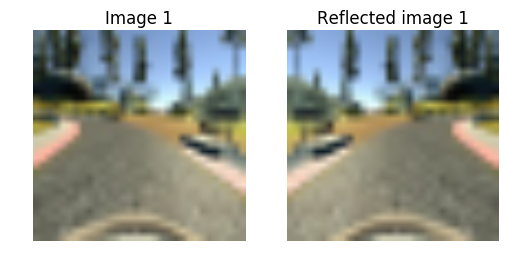

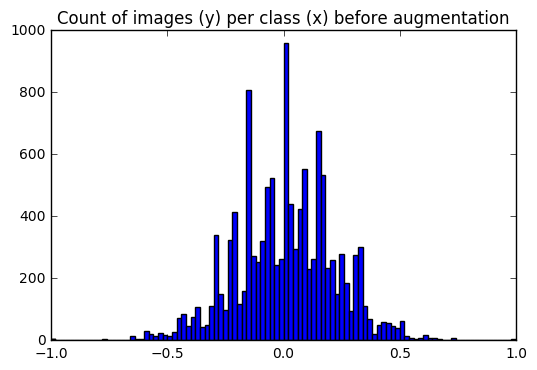

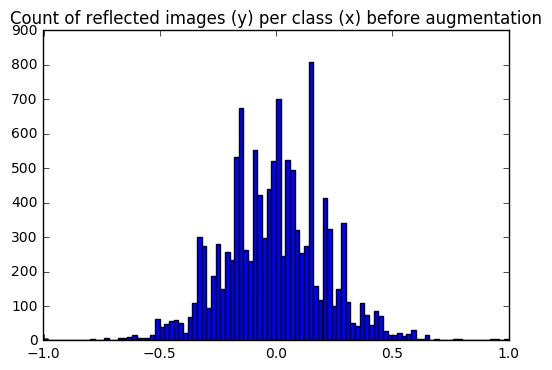

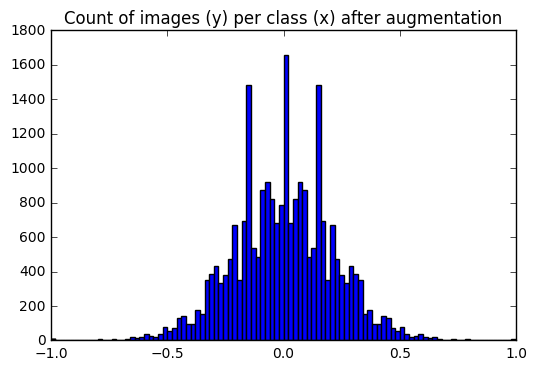

0.0
-0.0


In [5]:
def balance(X_input, y_input):
    """
    It will take the data input and attempt to balance the data set so that
    the training isn't squewed towards any given class
    """
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(X_train[0])
    axes[0].set_title("Image 1")
    axes[0].axis("off")
    axes[1].imshow(reflect_image(X_train[0]))
    axes[1].set_title("Reflected image 1")
    axes[1].axis("off")
    plt.show()
    plt.hist(y_input, bins=100)
    plt.title("Count of images (y) per class (x) before augmentation")
    plt.show()
    tupni_X = [reflect_image(i) for i in X_input]
    tupni_y = [-i for i in y_input]
    plt.show()
    plt.hist(tupni_y, bins=100)
    plt.title("Count of reflected images (y) per class (x) before augmentation")
    plt.show()
    X_output = np.concatenate((X_input, tupni_X), axis=0)
    y_output = np.concatenate((y_input, tupni_y), axis=0)
    plt.hist(y_output, bins=100)
    plt.title("Count of images (y) per class (x) after augmentation")
    plt.show()
    print(y_input[0])
    print(tupni_y[0])
    return X_output, y_output

source = "./data/"
data_pickle = source + "data.pickle"
if os.path.exists(data_pickle):
    os.remove(data_pickle)

X_train, y_train = load_data(source)
X_train, y_train = balance(X_train, y_train)


In [6]:
def normalize_minmax(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

** Model definition **

Function that creates the model

In [7]:
def make_model(n_classes, dropout_rate=0.5, regularizer_rate=0.0001):
    """
    Creates the keras model used for our network
    """
    model = Sequential()
    # Add a convolution with 32 filters, 3x3 kernel, and valid padding
    model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(32, 32, 3)))
    # Add a max pooling of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a ReLU activation layer
    model.add(Activation('relu'))
    # Add a dropout
    model.add(Dropout(dropout_rate))

    # Add a convolution with 64 filters, 2x2 kernel, and valid padding
    model.add(Convolution2D(64, 2, 2, border_mode='valid'))
    # Add a max pooling of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a ReLU activation layer
    model.add(Activation('relu'))
    # Add a dropout
    model.add(Dropout(dropout_rate))

    # Add a flatten layer
    model.add(Flatten())
    # Add a fully connected layer
    #model.add(Dense(128, W_regularizer=l2(regularizer_rate), activity_regularizer=activity_l2(regularizer_rate)))
    model.add(Dense(128))
    # Add a ReLU activation layer
    model.add(Activation('relu'))
    # Add a dropout
    model.add(Dropout(dropout_rate))
    # Add a fully connected layer
    #model.add(Dense(n_classes, W_regularizer=l2(regularizer_rate), activity_regularizer=activity_l2(regularizer_rate)))
    model.add(Dense(n_classes))
    print(model.summary())

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

** Training **

Instantiate a model and train it with the data in disk

In [24]:
# instantiate the model
model = make_model(1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 15, 15, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 15, 15, 32)    0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 15, 15, 32)    0           activation_1[0][0]               
___________________________________________________________________________________________

Training data from ./data/
Loading data from pickle file...


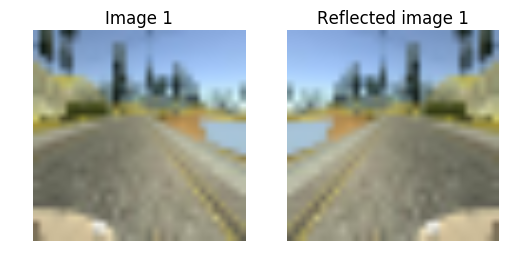

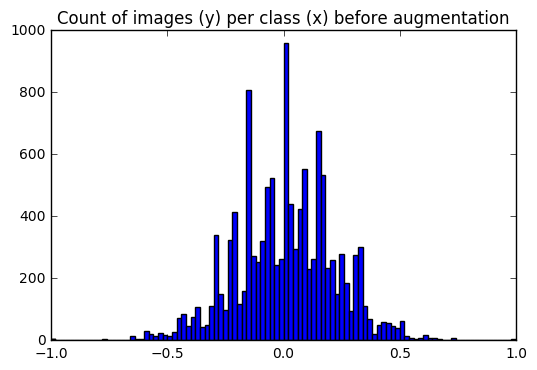

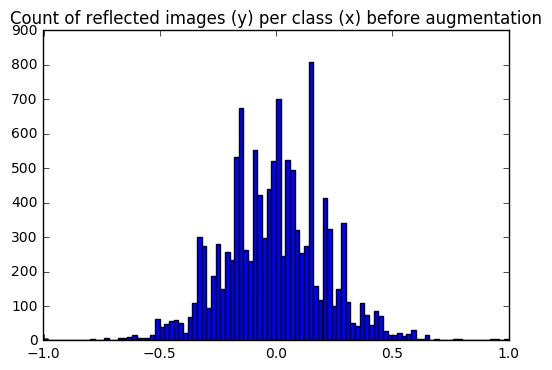

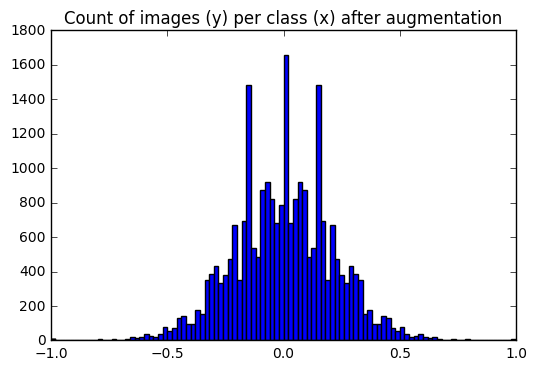

-0.0331838
0.0331838
Train on 19742 samples, validate on 4936 samples
Epoch 1/100
19742/19742 [==============================] - 7s - loss: 0.0665 - acc: 0.0344 - val_loss: 0.0462 - val_acc: 0.0381
Epoch 2/100
19742/19742 [==============================] - 1s - loss: 0.0472 - acc: 0.0348 - val_loss: 0.0455 - val_acc: 0.0381
Epoch 3/100
19742/19742 [==============================] - 1s - loss: 0.0443 - acc: 0.0348 - val_loss: 0.0407 - val_acc: 0.0381
Epoch 4/100
19742/19742 [==============================] - 1s - loss: 0.0352 - acc: 0.0348 - val_loss: 0.0297 - val_acc: 0.0381
Epoch 5/100
19742/19742 [==============================] - 1s - loss: 0.0296 - acc: 0.0348 - val_loss: 0.0256 - val_acc: 0.0381
Epoch 6/100
19742/19742 [==============================] - 1s - loss: 0.0269 - acc: 0.0348 - val_loss: 0.0237 - val_acc: 0.0381
Epoch 7/100
19742/19742 [==============================] - 1s - loss: 0.0252 - acc: 0.0348 - val_loss: 0.0220 - val_acc: 0.0381
Epoch 8/100
19742/19742 [=========

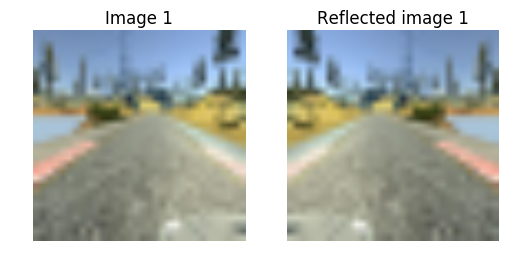

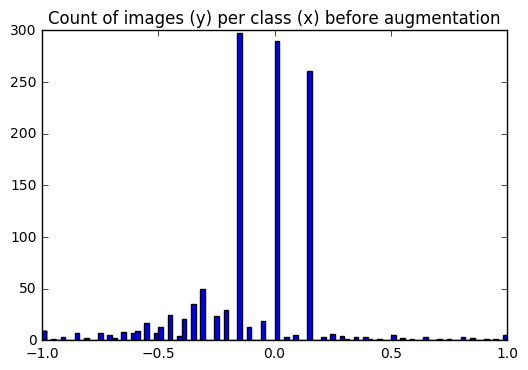

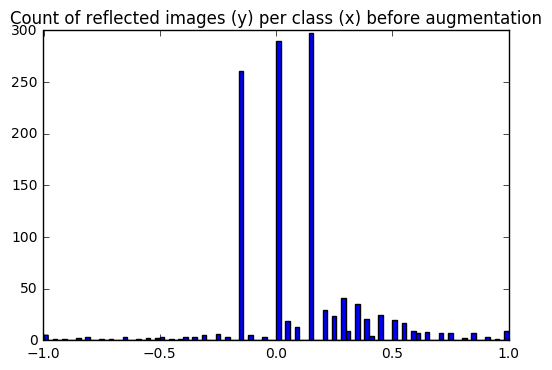

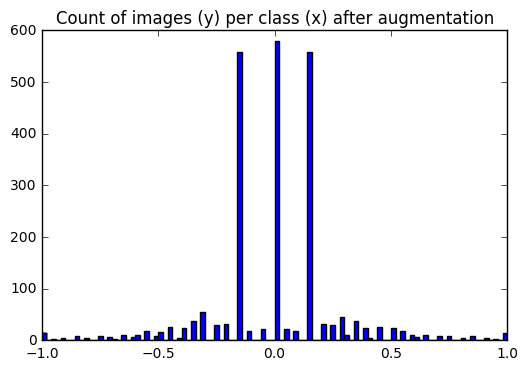

-0.15
0.15
Train on 1953 samples, validate on 489 samples
Epoch 1/100
1953/1953 [==============================] - 0s - loss: 0.0443 - acc: 0.2412 - val_loss: 0.0467 - val_acc: 0.2249
Epoch 2/100
1953/1953 [==============================] - 0s - loss: 0.0421 - acc: 0.2422 - val_loss: 0.0438 - val_acc: 0.2249
Epoch 3/100
1953/1953 [==============================] - 0s - loss: 0.0413 - acc: 0.2417 - val_loss: 0.0437 - val_acc: 0.2249
Epoch 4/100
1953/1953 [==============================] - 0s - loss: 0.0400 - acc: 0.2427 - val_loss: 0.0454 - val_acc: 0.2270
Epoch 5/100
1953/1953 [==============================] - 0s - loss: 0.0378 - acc: 0.2448 - val_loss: 0.0421 - val_acc: 0.2270
Epoch 6/100
1953/1953 [==============================] - 0s - loss: 0.0370 - acc: 0.2453 - val_loss: 0.0425 - val_acc: 0.2270
Epoch 7/100
1953/1953 [==============================] - 0s - loss: 0.0359 - acc: 0.2458 - val_loss: 0.0409 - val_acc: 0.2270
Epoch 8/100
1953/1953 [==============================] - 0s 

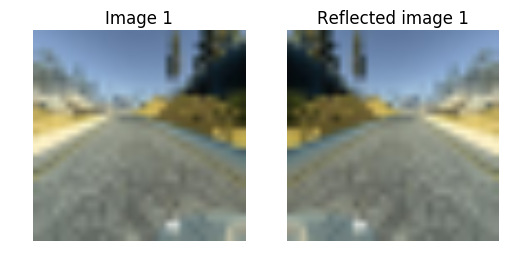

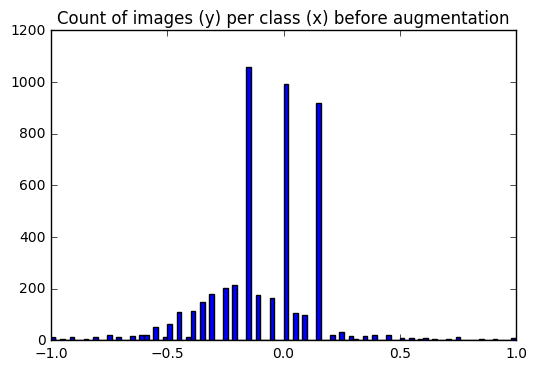

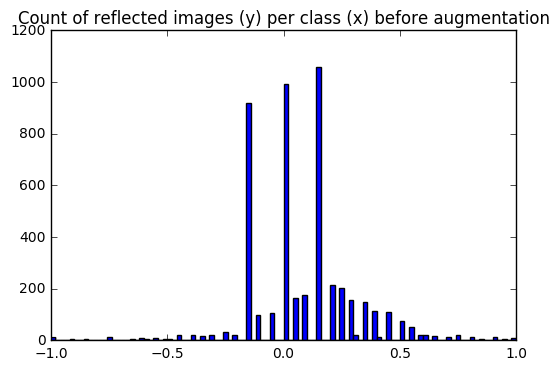

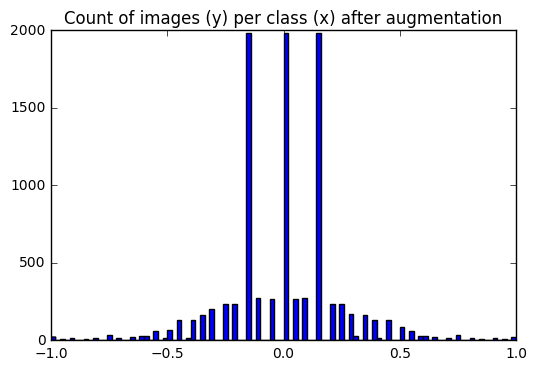

-0.55
0.55
Train on 7972 samples, validate on 1994 samples
Epoch 1/100
7972/7972 [==============================] - 0s - loss: 0.0391 - acc: 0.1988 - val_loss: 0.0333 - val_acc: 0.1956
Epoch 2/100
7972/7972 [==============================] - 0s - loss: 0.0318 - acc: 0.2002 - val_loss: 0.0317 - val_acc: 0.1956
Epoch 3/100
7972/7972 [==============================] - 0s - loss: 0.0303 - acc: 0.2002 - val_loss: 0.0293 - val_acc: 0.1956
Epoch 4/100
7972/7972 [==============================] - 0s - loss: 0.0294 - acc: 0.2007 - val_loss: 0.0299 - val_acc: 0.1956
Epoch 5/100
7972/7972 [==============================] - 0s - loss: 0.0291 - acc: 0.2001 - val_loss: 0.0307 - val_acc: 0.1956
Epoch 6/100
7972/7972 [==============================] - 0s - loss: 0.0287 - acc: 0.2005 - val_loss: 0.0299 - val_acc: 0.1956
Epoch 7/100
7972/7972 [==============================] - 0s - loss: 0.0281 - acc: 0.2002 - val_loss: 0.0293 - val_acc: 0.1956
Epoch 8/100
7972/7972 [==============================] - 0s

In [25]:
# train the model

for source in ["./data/", "./data-david-track1-1/", "./data-david-track1-2/"]:
    print("Training data from", source)
    X_train, y_train = load_data(source)
    X_train, y_train = shuffle(X_train, y_train)
    n_train = len(X_train)
    X_train, y_train = balance(X_train, y_train)
    X_normalized = normalize_minmax(X_train)
    y_normalized = y_train
    history = model.fit(X_normalized, y_normalized, batch_size=512, nb_epoch=100, validation_split=0.2)

print("Done training")

In [26]:
# save model to disk
model_filepath = "./model.h5"
if os.path.exists(model_filepath):
    os.remove(model_filepath)
model.save(model_filepath)

** Let's run some validations on the model **


In [27]:
from keras.models import load_model

test_model = load_model(model_filepath)

source = "./data/"
X_test, y_test = load_data(source)
X_test, y_test = shuffle(X_test, y_test)


Loading data from pickle file...


In [33]:
n_test = len(test_image)
index = random.randint(0, n_test)
test_image = X_test[index]
test_result = y_test[index]

result = float(test_model.predict(test_image[None, :, :, :], batch_size=1))

print("Expected", test_result, "obtained", result)

Expected 0.5784606 obtained 0.6925882697105408
